In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Load and preprocess the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.drop(columns=['image_name', 'label'])  # Assuming 'filename' and 'label' columns exist
    y = data['label']  # Labels: 'injured', 'not injured', 'unknown'

    # If there are less than 25 points, classify as unknown
    X['point_count'] = X.count(axis=1)
    y[X['point_count'] < 25] = 'unknown'
    X = X.drop(columns=['point_count'])
    
    # Convert labels to one-hot encoding
    y = pd.get_dummies(y, columns=['label'])
    
    # Print class distribution
    print("Class distribution:")
    print(data['label'].value_counts())

    return X.values, y.values

In [11]:
def build_model(input_shape, optimizer, l2_reg_factor=0.01):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    # 7 hidden layers
    for _ in range(7):
        model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2_reg_factor)))
        model.add(tf.keras.layers.Dropout(0.3))  # Dropout for regularization
    
    # Output layer
    model.add(tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(l2_reg_factor)))  # 3 output classes

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
# Plot comparison between two optimizers
def plot_comparison(history_sgd, history_adam):
    epochs = range(1, 17)

    # Accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history_sgd.history['accuracy'], label='SGD Training Accuracy')
    plt.plot(epochs, history_sgd.history['val_accuracy'], label='SGD Validation Accuracy')
    plt.plot(epochs, history_adam.history['accuracy'], label='Adam Training Accuracy')
    plt.plot(epochs, history_adam.history['val_accuracy'], label='Adam Validation Accuracy')
    plt.title('Optimizer Comparison: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss comparison
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history_sgd.history['loss'], label='SGD Training Loss')
    plt.plot(epochs, history_sgd.history['val_loss'], label='SGD Validation Loss')
    plt.plot(epochs, history_adam.history['loss'], label='Adam Training Loss')
    plt.plot(epochs, history_adam.history['val_loss'], label='Adam Validation Loss')
    plt.title('Optimizer Comparison: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [18]:
# Plot learning rate per epoch
def plot_learning_rate(learning_rates_sgd, learning_rates_adam):
    epochs = range(1, len(learning_rates_sgd) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, learning_rates_sgd, label='SGD Learning Rate')
    plt.plot(epochs, learning_rates_adam, label='Adam Learning Rate')
    plt.title('Learning Rate per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

class LearningRateTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateTracker, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.learning_rates.append(lr)


# Print confusion matrix
def print_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print("\nConfusion Matrix Interpretation:")
    print(f"True Positives: {cm[1][1]}, False Positives: {cm[0][1]}")
    print(f"False Negatives: {cm[1][0]}, True Negatives: {cm[0][0]}")

In [23]:
# Train and evaluate the model with different optimizers and learning rates
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    optimizers = {
        'Adam': tf.keras.optimizers.Adam,
        'SGD': tf.keras.optimizers.SGD
    }
    
    # Learning Rate Scheduler: Reduce LR when validation loss plateaus
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        min_lr=0.00001, 
        verbose=1
    )
    
    best_f1 = 0
    best_history = None
    best_model = None
    best_optimizer_name = None
    sgd_history = None
    adam_history = None
    sgd_lr_tracker = LearningRateTracker()  # Assuming you have this defined elsewhere
    adam_lr_tracker = LearningRateTracker()  # Assuming you have this defined elsewhere

    for optimizer_name, optimizer in optimizers.items():
        print(f"Training with {optimizer_name} (initial learning rate = 0.001)")
        model = build_model(input_shape=(X_train.shape[1],), optimizer=optimizer(learning_rate=0.001))
        
        # Attach the corresponding learning rate tracker
        lr_tracker = sgd_lr_tracker if optimizer_name == 'SGD' else adam_lr_tracker

        history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_split=0.2, verbose=2, 
                            callbacks=[reduce_lr, lr_tracker])

        # Evaluate on the test set
        y_pred = model.predict(X_test)
        
        # Convert predictions to class indices
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Handle potential one-hot encoding for y_test
        if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check if y_test is one-hot encoded
            y_test_labels = np.argmax(y_test, axis=1)
        else:
            y_test_labels = y_test

        f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
        print(f"F1-score: {f1:.4f}")
        
        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            best_history = history
            best_model = model
            best_optimizer_name = optimizer_name
        
        # Store the history for optimizer comparison
        if optimizer_name == 'SGD':
            sgd_history = history
        if optimizer_name == 'Adam':
            adam_history = history

    print(f"\nBest Model: {best_optimizer_name} with F1 score: {best_f1:.4f}")
    
    # Plot comparison between SGD and Adam
    plot_comparison(sgd_history, adam_history)

    # Plot learning rate evolution for both optimizers
    plot_learning_rate(sgd_lr_tracker.learning_rates, adam_lr_tracker.learning_rates)
    
    # Confusion matrix and classification report for best model
    y_pred_best = best_model.predict(X_test)
    y_pred_best_labels = np.argmax(y_pred_best, axis=1)
    
    print_confusion_matrix(y_test_labels, y_pred_best_labels, class_names=['Injured', 'Not Injured', 'Unknown'])
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_best_labels, target_names=['Injured', 'Not Injured', 'Unknown']))

Class distribution:
label
INJURED        62
NOT INJURED    45
UNKNOWN         9
Name: count, dtype: int64
Training with Adam (initial learning rate = 0.001)
Epoch 1/16


/tmp/ipykernel_28861/3452140399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[X['point_count'] < 25] = 'unknown'
/home/marius/Desktop/Python/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 - 2s - 569ms/step - accuracy: 0.1918 - loss: 1.4375 - val_accuracy: 0.6316 - val_loss: 1.0820 - learning_rate: 0.0010
Epoch 2/16
3/3 - 0s - 12ms/step - accuracy: 0.3699 - loss: 1.1568 - val_accuracy: 0.6316 - val_loss: 1.0606 - learning_rate: 0.0010
Epoch 3/16
3/3 - 0s - 10ms/step - accuracy: 0.4247 - loss: 1.1013 - val_accuracy: 0.6316 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 4/16
3/3 - 0s - 11ms/step - accuracy: 0.5479 - loss: 1.0464 - val_accuracy: 0.6316 - val_loss: 1.0332 - learning_rate: 0.0010
Epoch 5/16
3/3 - 0s - 11ms/step - accuracy: 0.4110 - loss: 1.0209 - val_accuracy: 0.6316 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 6/16
3/3 - 0s - 10ms/step - accuracy: 0.5068 - loss: 1.0303 - val_accuracy: 0.6316 - val_loss: 1.0106 - learning_rate: 0.0010
Epoch 7/16
3/3 - 0s - 10ms/step - accuracy: 0.4932 - loss: 0.9503 - val_accuracy: 0.5789 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 8/16
3/3 - 0s - 11ms/step - accuracy: 0.3836 - loss: 0.9680 - val_accuracy: 0.63

/home/marius/Desktop/Python/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 - 1s - 255ms/step - accuracy: 0.4110 - loss: 1.2187 - val_accuracy: 0.3158 - val_loss: 1.0958 - learning_rate: 0.0010
Epoch 2/16
3/3 - 0s - 11ms/step - accuracy: 0.3836 - loss: 1.0985 - val_accuracy: 0.3158 - val_loss: 1.0946 - learning_rate: 0.0010
Epoch 3/16
3/3 - 0s - 10ms/step - accuracy: 0.3699 - loss: 1.2269 - val_accuracy: 0.4211 - val_loss: 1.0926 - learning_rate: 0.0010
Epoch 4/16
3/3 - 0s - 10ms/step - accuracy: 0.3836 - loss: 1.1948 - val_accuracy: 0.5263 - val_loss: 1.0915 - learning_rate: 0.0010
Epoch 5/16
3/3 - 0s - 11ms/step - accuracy: 0.3151 - loss: 1.2558 - val_accuracy: 0.5789 - val_loss: 1.0901 - learning_rate: 0.0010
Epoch 6/16
3/3 - 0s - 11ms/step - accuracy: 0.3836 - loss: 1.1574 - val_accuracy: 0.5789 - val_loss: 1.0890 - learning_rate: 0.0010
Epoch 7/16
3/3 - 0s - 11ms/step - accuracy: 0.3562 - loss: 1.2523 - val_accuracy: 0.5789 - val_loss: 1.0881 - learning_rate: 0.0010
Epoch 8/16
3/3 - 0s - 11ms/step - accuracy: 0.2877 - loss: 1.2814 - val_accuracy: 0.63

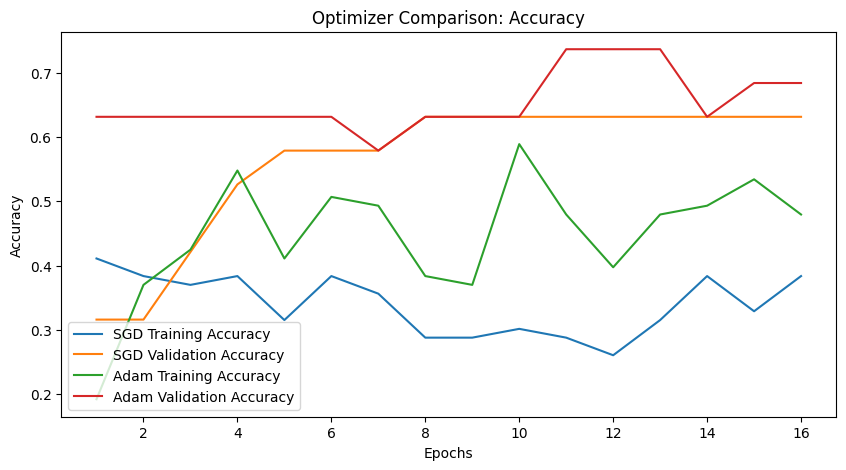

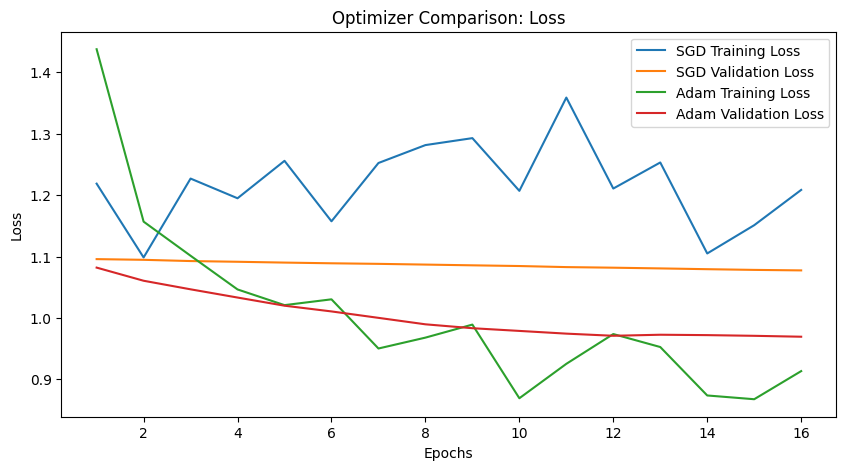

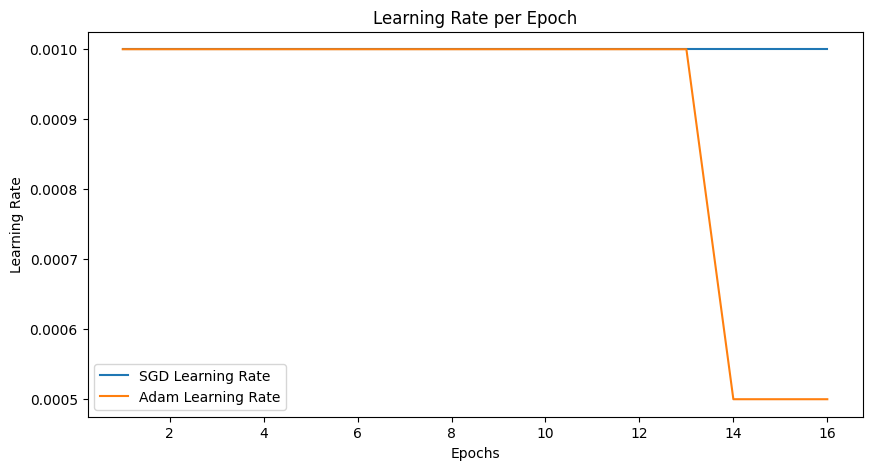

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


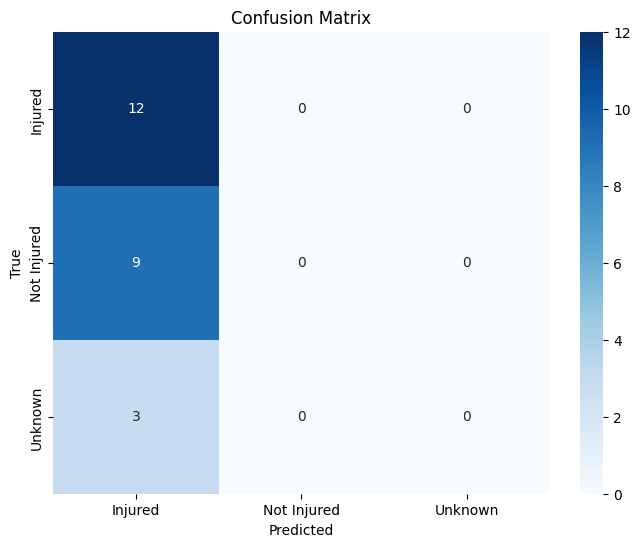


Confusion Matrix Interpretation:
True Positives: 0, False Positives: 0
False Negatives: 9, True Negatives: 12

Classification Report:
              precision    recall  f1-score   support

     Injured       0.50      1.00      0.67        12
 Not Injured       0.00      0.00      0.00         9
     Unknown       0.00      0.00      0.00         3

    accuracy                           0.50        24
   macro avg       0.17      0.33      0.22        24
weighted avg       0.25      0.50      0.33        24



/home/marius/Desktop/Python/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marius/Desktop/Python/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marius/Desktop/Python/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [24]:
# Load the dataset and run the evaluation
file_path = 'pose_keypoints_and_labels.csv'  # Adjust the path to your CSV file
X, y = load_data(file_path)
evaluate_model(X, y)
